### Типы задач при работе с последовательностями



*  **One-to-one** - один вход и один выход. Это самый простой случай, под который подпадают такие задачи, как классификация изображений, где одно изображение соответствует одной метке.
*  **One-to-many** - один вход и несколько выходов. Пример задачи - генерация подписей для изображения.
* **Many-to-one** - типичный пример - классификация текстов.
* **Many-to-many** v1 - последовательности разной длины на входе и на выходе. Применяется в таких задачах, как машинный перевод, где предложение на одном языке переводится в предложение на другом языке, но, вероятно, с другим количеством токенов.
* **Many-to-many** v2 - последовательности одной длины на входе и на выходе. Применяется в таких задачах, как NER, POS-tagging, где каждому токену входа сопоставляется свой выход.



## Архитектура encoder-decoder для машинного перевода

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

from sklearn.model_selection import train_test_split
from vocab import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

## Машинный перевод

Попробуем решить задачу машинного перевода с русского на английский. В частности, будем работать с описаниями отелей.

Прежде чем перейти к  реализации архитектуры, необходимо выполнить некоторую предварительную обработку - токенизацию.

Данные содержат уникальные редкие слова. Если мы работаем на уровне слов, нам придется иметь дело с большим словарем. Если вместо этого мы будем использовать модели на уровне отдельных символов, для обработки последовательности потребуется много итераций. На этот раз мы выберем нечто среднее.

Один из популярных подходов называется [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt) , также известный как BPE. Алгоритм начинается с токенизации на уровне символов, а затем итеративно объединяет наиболее часто встречающиеся пары в течение N итераций. Это приводит к тому, что часто встречающиеся слова объединяются в один токен, а редкие слова разбиваются на слоги или даже символы.




### Подгрузка данных

In [ ]:
!wget https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1 -O data.txt

--2025-03-06 20:49:09--  https://www.dropbox.com/s/yy2zqh34dyhv07i/data.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1 [following]
--2025-03-06 20:49:09--  https://www.dropbox.com/scl/fi/mw8tdyetqboqwkn5ma886/data.txt?rlkey=t9fmsizx27ikh0vak0ir265a6&dl=1
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucefced7de5f501dec4f65f0f50f.dl.dropboxusercontent.com/cd/0/inline/ClZ0PMyQg18jNoDpmH3cIjOSJ9jHbN1Th6YYROVg0BmYu0VAOyHa4T7PuUP0tjdtDn6McQIwm99XoQpxAYAPK5SetINbkvMmTU4C5FxPVLd1tBWceFFLzOfrgX9LUjaYAII/file?dl=1# [following]
--2025-03-06 20:49:09--  https://ucefced7de5f501dec4f65f0f50f.dl.dropboxusercontent.com/cd/0/inline/ClZ0PMyQg18

In [2]:
with open('data.txt') as f:
  print(f.readlines()[0])

Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.	Отель Cordelia расположен в Тбилиси, в 3 минутах ходьбы от Свято-Троицкого собора.



### BPE

[Subword Neural Machine Translation](https://github.com/rsennrich/subword-nmt) - Unsupervised Word Segmentation for Neural Machine Translation and Text Generation

In [ ]:
!pip install subword-nmt

In [3]:
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

In [4]:
tokenizer = WordPunctTokenizer()

def tokenize(x):
  return ' '.join(tokenizer.tokenize(x.lower()))

In [5]:
with open('train.en', 'w') as f_src,  open('train.ru', 'w') as f_dst:
  for line in open('data.txt'):
    src_line, dst_line = line.strip().split('\t')
    f_src.write(tokenize(src_line) + '\n')
    f_dst.write(tokenize(dst_line) + '\n')

In [6]:
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=8000)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))

    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

100%|██████████| 8000/8000 [00:03<00:00, 2010.62it/s]


### Построение словарей


In [7]:
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,
)

for i in range(3):
    print('inp:', train_inp[i])
    print('out:', train_out[i], end='\n\n')

inp: этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .
out: this hotel is located in the centre of paris , 2 minutes from place de la ré@@ pub@@ li@@ que and its metro station , which offers 5 metro lines and 4 bus lines .

inp: на полностью оборудованной мини - кухне можно самостоятельно готовить .
out: there is a full kitchenette where guests are welcome to prepare their meals .

inp: номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .
out: set under the roof or on the lower floors with bay windows looking out onto the park , they are all equipped with wi - fi access .



In [8]:
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

In [9]:
batch_lines = sorted(train_inp, key=len)[5:10]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']

words to ids (0 = bos, 1 = eos):
tensor([[   0, 2688, 2943, 1109,   29,    1,    1,    1],
        [   0, 3486, 1869,   29,    1,    1,    1,    1],
        [   0, 2922, 1833, 8034,   59, 3799,   29,    1],
        [   0, 6028, 2083,   29,    1,    1,    1,    1],
        [   0, 4927, 1869,   29,    1,    1,    1,    1]])

back to words
['гостевой дом r .', 'имеется балкон .', 'до афин — 20 км .', 'работает боулинг .', 'оборудован балкон .']


Распределения длин исходных текстов и переводов

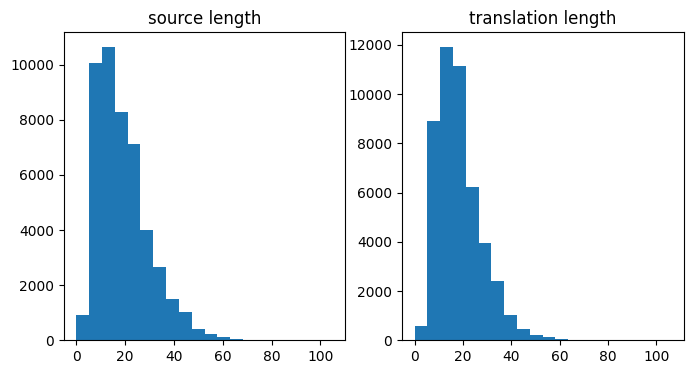

In [10]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(map(len, map(str.split, train_inp))), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(map(len, map(str.split, train_out))), bins=20);

### Encoder-decoder model


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'

device

'mps'

In [13]:
class BasicModel(nn.Module):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128):
        """
        A simple encoder-decoder seq2seq model
        """
        super().__init__()

        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.enc0 = nn.GRU(emb_size, hid_size, batch_first=True)

        self.dec_start = nn.Linear(hid_size, hid_size)
        self.dec0 = nn.GRUCell(emb_size, hid_size)
        self.logits = nn.Linear(hid_size, len(out_voc))

    def forward(self, inp, out):
        """ Apply model in training mode """
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)


    def encode(self, inp, **flags):
        """
        Takes input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :returns: initial decoder state tensors, one or many
        """
        inp_emb = self.emb_inp(inp)
        batch_size = inp.shape[0]

        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        # enc_seq: [batch, sequence length, hid_size], last_state: [batch, hid_size]

        # note: last_state is not _actually_ last because of padding, let's find the real last_state
        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]

        dec_start = self.dec_start(last_state)
        return [dec_start]

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors, same as returned by encode(...)
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, len(out_voc)]
        """
        prev_gru0_state = prev_state[0]
        prev_emb = self.emb_out(prev_tokens)
        new_dec_state = self.dec0(prev_emb, prev_gru0_state) # input & hidden states
        output_logits = self.logits(new_dec_state)

        return [new_dec_state], output_logits

    def decode(self, initial_state, out_tokens, **flags):
        """ Iterate over reference tokens (out_tokens) with decode_step """
        batch_size = out_tokens.shape[0]
        state = initial_state

        # initial logits: always predict BOS
        onehot_bos = F.one_hot(torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
                               num_classes=len(self.out_voc)).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)

        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        return torch.stack(logits_sequence, dim=1)

    def decode_inference(self, initial_state, max_len=100, **flags):
        """ Generate translations from model (greedy version) """
        batch_size, device = len(initial_state[0]), initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64,
                              device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)

        return torch.stack(outputs, dim=1), all_states

    def translate_lines(self, inp_lines, **kwargs):
        inp = self.inp_voc.to_matrix(inp_lines).to(device)
        initial_state = self.encode(inp)
        out_ids, states = self.decode_inference(initial_state, **kwargs)
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states


In [14]:
model = BasicModel(inp_voc, out_voc).to(device)

dummy_inp_tokens = inp_voc.to_matrix(sorted(train_inp, key=len)[5:10]).to(device)
dummy_out_tokens = out_voc.to_matrix(sorted(train_out, key=len)[5:10]).to(device)

h0 = model.encode(dummy_inp_tokens)
h1, logits1 = model.decode_step(h0, torch.arange(len(dummy_inp_tokens), device=device))

assert isinstance(h1, list) and len(h1) == len(h0)
assert h1[0].shape == h0[0].shape and not torch.allclose(h1[0], h0[0])
assert logits1.shape == (len(dummy_inp_tokens), len(out_voc))

logits_seq = model.decode(h0, dummy_out_tokens)
assert logits_seq.shape == (dummy_out_tokens.shape[0], dummy_out_tokens.shape[1], len(out_voc))

# full forward
logits_seq2 = model(dummy_inp_tokens, dummy_out_tokens)
assert logits_seq2.shape == logits_seq.shape

In [15]:
train_inp[:3]

array(['этот отель находится в центре парижа , в 2 минутах от площади республики и станции метро с 5 лини@@ ями метро и 4 автобус@@ ными маршру@@ тами .',
       'на полностью оборудованной мини - кухне можно самостоятельно готовить .',
       'номера находятся под кры@@ шей или на ниж@@ них эта@@ жах с эр@@ ке@@ рами с видом на сад .'],
      dtype='<U524')

In [16]:
dummy_translations, dummy_states = model.translate_lines(train_inp[:3], max_len=25)
print("Translations without training:")
print('\n'.join([line for line in dummy_translations]))

Translations without training:
kass@@ willa lic adi pacif@@ great bau@@ marmara eden tos tourism necess@@ ily ün@@ gorges guest dumont omo omo omo omo li@@ ya crete ya
designs ku@@ cia serviced furnishings donia dra donia ational går@@ villas shan@@ machine machine monitored minh latin rita opening opening opening consi@@ club â res
cia concert jas@@ santo söl@@ è@@ nizh@@ goth@@ ü@@ el front september marac@@ tte falcone apartman lou@@ victorian 16 argent@@ corri@@ jav@@ penang horse rita


### Loss

Будем минимизировать categorical crossentropy во время обучения на данных $D$:
$$ L = {\frac1{|D|}} \sum_{X, Y \in D} \sum_{y_t \in Y} - \log p(y_t \mid y_1, \dots, y_{t-1}, X, \theta) $$

$|D|$ - длина всех последовательностей, включая BOS and первые EOS токены, кроме PAD

In [17]:
def compute_loss(model, inp, out, **flags):
    """
    Compute loss (float32 scalar) as in the formula above
    :param inp: input tokens matrix, int32[batch, time]
    :param out: reference tokens matrix, int32[batch, time]

    In order to pass the tests, your function should
    * include loss at first EOS but not the subsequent ones
    * divide sum of losses by a sum of input lengths (use voc.compute_mask)
    """
    mask = model.out_voc.compute_mask(out) # [batch_size, out_len]
    targets_1hot = F.one_hot(out, len(model.out_voc)).to(torch.float32)

    # outputs of the model, [batch_size, out_len, num_tokens]
    logits_seq = model(inp, out)

    # log-probabilities of all tokens at all steps, [batch_size, out_len, num_tokens]
    logprobs_seq = torch.log_softmax(logits_seq, dim=-1)

    # log-probabilities of correct outputs, [batch_size, out_len]
    logp_out = (logprobs_seq * targets_1hot).sum(dim=-1)
    # ^-- this will select the probability of the actual next token.
    # Note: you can compute loss more efficiently using using F.cross_entropy

    # average cross-entropy over tokens where mask == True
    return -logp_out[mask].mean()

In [18]:
dummy_loss = compute_loss(model, dummy_inp_tokens, dummy_out_tokens)
print("Loss:", dummy_loss)
assert np.allclose(dummy_loss.item(), 7.5, rtol=0.1, atol=0.1), "We're sorry for your loss"

# test autograd
dummy_loss.backward()
for name, param in model.named_parameters():
    assert param.grad is not None and abs(param.grad.max()) != 0, f"Param {name} received no gradients"

Loss: tensor(7.5771, device='mps:0', grad_fn=<NegBackward0>)


### Оценка качества: BLEU

Распространенная матрика машинного перевода - [BLEU](https://en.wikipedia.org/wiki/BLEU). Эта метрика вычисляет долю верно предсказанных n-grams. В частности, например, для n=1, 2, 3, 4 она вычисляется как геометрическое среднее со штрафом за короткие переводы.


[Эволюция метрик качества машинного перевода](https://habr.com/ru/articles/745642/)

In [19]:
def compute_bleu(model, inp_lines, out_lines, bpe_sep='@@ ', **flags):
    """
    Estimates corpora-level BLEU score of model's translations given inp and reference out
    """
    with torch.no_grad():
        translations, _ = model.translate_lines(inp_lines, **flags)
        translations = [line.replace(bpe_sep, '') for line in translations]
        actual = [line.replace(bpe_sep, '') for line in out_lines]
        return corpus_bleu(
            [[ref.split()] for ref in actual],
            [trans.split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100

In [20]:
compute_bleu(model, dev_inp, dev_out)

0.001833023220580239

### Training loop

Training encoder-decoder models isn't that different from any other models: sample batches, compute loss, backprop and update

In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = BasicModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

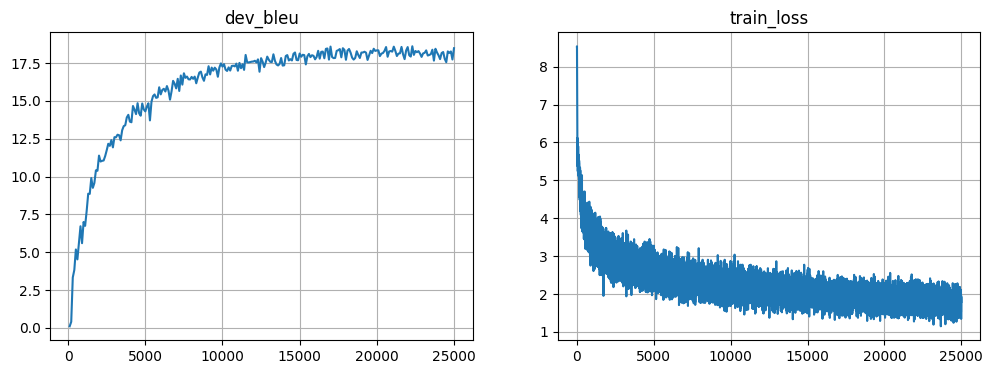

Mean loss=1.734


100%|██████████| 25000/25000 [19:51<00:00, 20.98it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

# Note: it's okay if bleu oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

In [ ]:
assert np.mean(metrics['dev_bleu'][-10:], axis=0)[1] > 15, "We kind of need a higher bleu BLEU from you. Kind of right now."

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
featuring a bath , the bathroom also comes with a bath .

на территории можно сыграть в дартс и сквош .
other facilities offered at the property include a games room , a dry cleaning and a billiards table .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests are fully equipped with a fully equipped kitchen and a coffee machine .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
the apartment will provide you with a tv and a bathroom with a bath or a bath or a bath or a bath or a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
guests can enjoy a drink at the on - site restaurant bar , which is open 24 - hours a day .



In [ ]:
compute_bleu(model, dev_inp, dev_out)

18.48366063575341

### Attention

Добавим простой attention:

Имея последовательность $ h^e_0, h^e_1, h^e_2, ..., h^e_T$ из encoder'а и decoder state $h^d$,

* Вычислим логиты двухслойной сеткой
$$a_t = linear_{out}(tanh(linear_{e}(h^e_t) + linear_{d}(h_d)))$$
* Получим вероятности,
$$ p_t = {{e ^ {a_t}} \over { \sum_\tau e^{a_\tau} }} $$

* Взвесим состояния encoder'а с вероятностями, чтобы получить **attention**
$$ attn = \sum_t p_t \cdot h^e_t $$

[Attention and Augmented Recurrent Neural Networks](https://distill.pub/2016/augmented-rnns/).

In [21]:
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, hid_size):
        """ A layer that computes additive attention response and weights """
        super().__init__()
        self.enc_size = enc_size # num units in encoder state
        self.dec_size = dec_size # num units in decoder state
        self.hid_size = hid_size # attention layer hidden units

        self.linear_enc = nn.Linear(enc_size, hid_size)
        self.linear_dec = nn.Linear(dec_size, hid_size)
        self.linear_out = nn.Linear(hid_size, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, enc, dec, inp_mask):
        """
        Computes attention response and weights
        :param enc: encoder activation sequence, float32[batch_size, ninp, enc_size]
        :param dec: single decoder state used as "query", float32[batch_size, dec_size]
        :param inp_mask: mask on enc activatons (0 after first eos), float32 [batch_size, ninp]
        :returns: attn[batch_size, enc_size], probs[batch_size, ninp]
            - attn - attention response vector (weighted sum of enc)
            - probs - attention weights after softmax
        """
        batch_size, ninp, enc_size = enc.shape

        # Compute logits
        x = self.linear_dec(dec).reshape(-1, 1, self.hid_size)
        x = torch.tanh(self.linear_enc(enc) + x)
        x = self.linear_out(x)

        # Apply mask - if mask is 0, logits should be -inf or -1e9
        # You may need torch.where
        x[torch.where(inp_mask == False)] = -1e9

        # Compute attention probabilities (softmax)
        probs = self.softmax(x.reshape(batch_size, ninp))

        # Compute attention response using enc and probs
        attn = (probs.reshape(batch_size, ninp, 1) * enc).sum(1)

        return attn, probs

### Seq2seq model + attention

Теперь можно использовать слой attention в Seq2Seq модели:
![img](https://i.imgur.com/6fKHlHb.png)
_image from distill.pub [article](https://distill.pub/2016/augmented-rnns/)_

На каждом шагу используем предыдущее состояние декодера для подсчета attention, затем приконкатенируем attention ко входам следующего слоя. T


In [22]:
class AttentiveModel(BasicModel):
    def __init__(self, inp_voc, out_voc, emb_size=64, hid_size=128, attn_size=128):
        """ Translation model that uses attention. See instructions above. """
        super().__init__(inp_voc, out_voc, emb_size, hid_size)
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size

        self.enc0 = nn.LSTM(emb_size, hid_size, num_layers=2, batch_first=True)
        self.dec_start = nn.Linear(hid_size, hid_size)

        self.dec0 = nn.GRUCell(emb_size + hid_size, hid_size)
        self.attention = AttentionLayer(hid_size, hid_size, attn_size)


    def encode(self, inp, **flags):
        """
        Takes input sequences, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        # encode input sequence, create initial decoder states
        inp_emb = self.emb_inp(inp)
        enc_seq, last_state_but_not_really = self.enc0(inp_emb)
        #[dec_start] = super().encode(inp, **flags)

        lengths = (inp != self.inp_voc.eos_ix).to(torch.int64).sum(dim=1).clamp_max(inp.shape[1] - 1)
        last_state = enc_seq[torch.arange(len(enc_seq)), lengths]
        # ^-- shape: [batch_size, hid_size]
        dec_start = self.dec_start(last_state)

        # apply attention layer from initial decoder hidden state
        inp_mask = self.out_voc.compute_mask(inp)
        first_attn_probas = self.attention(enc_seq, dec_start, inp_mask)

        # Build first state: include
        # * initial states for decoder recurrent layers
        # * encoder sequence and encoder attn mask (for attention)
        # * make sure that last state item is attention probabilities tensor

        first_state = [dec_start, enc_seq, inp_mask, first_attn_probas]
        return first_state

    def decode_step(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits for next tokens
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch, n_tokens]
        """

        prev_gru0_state, enc_seq, enc_mask, _ = prev_state
        attn, attn_probs = self.attention(enc_seq, prev_gru0_state, enc_mask)

        x = self.emb_out(prev_tokens)
        x = torch.cat([attn, x], dim=-1)
        x = self.dec0(x, prev_gru0_state)

        new_dec_state = [x, enc_seq, enc_mask, attn_probs]
        output_logits = self.logits(x)
        return [new_dec_state, output_logits]


### Training loop - модель с Attention


In [ ]:
metrics = {'train_loss': [], 'dev_bleu': [] }

model = AttentiveModel(inp_voc, out_voc).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
batch_size = 32

In [ ]:
model

AttentiveModel(
  (emb_inp): Embedding(8047, 64)
  (emb_out): Embedding(7800, 64)
  (enc0): LSTM(64, 128, num_layers=2, batch_first=True)
  (dec_start): Linear(in_features=128, out_features=128, bias=True)
  (dec0): GRUCell(192, 128)
  (logits): Linear(in_features=128, out_features=7800, bias=True)
  (attention): AttentionLayer(
    (linear_enc): Linear(in_features=128, out_features=128, bias=True)
    (linear_dec): Linear(in_features=128, out_features=128, bias=True)
    (linear_out): Linear(in_features=128, out_features=1, bias=True)
    (softmax): Softmax(dim=-1)
  )
)

In [ ]:
compute_bleu(model, dev_inp, dev_out)

0.0020633142012208075

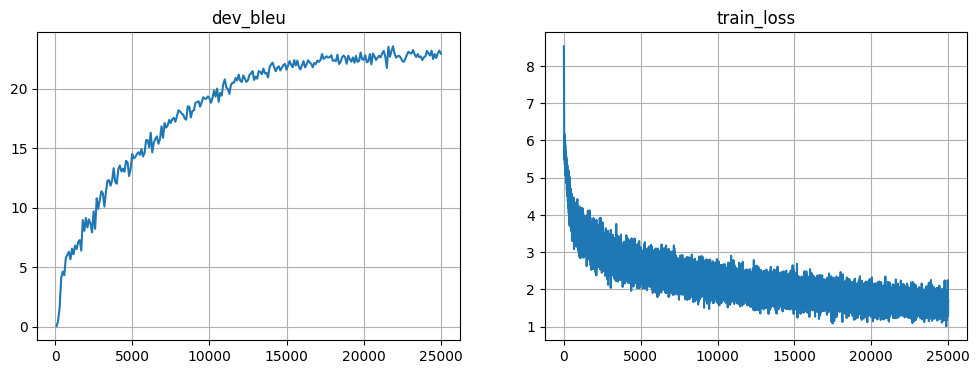

Mean loss=1.585


100%|██████████| 25000/25000 [53:46<00:00,  7.75it/s]


In [ ]:
for _ in trange(25000):
    step = len(metrics['train_loss']) + 1
    batch_ix = np.random.randint(len(train_inp), size=batch_size)
    batch_inp = inp_voc.to_matrix(train_inp[batch_ix]).to(device)
    batch_out = out_voc.to_matrix(train_out[batch_ix]).to(device)

    opt.zero_grad()
    loss_t = compute_loss(model, batch_inp, batch_out)
    loss_t.backward()
    opt.step()

    metrics['train_loss'].append((step, loss_t.item()))

    if step % 100 == 0:
        metrics['dev_bleu'].append((step, compute_bleu(model, dev_inp, dev_out)))

        clear_output(True)
        plt.figure(figsize=(12,4))
        for i, (name, history) in enumerate(sorted(metrics.items())):
            plt.subplot(1, len(metrics), i + 1)
            plt.title(name)
            plt.plot(*zip(*history))
            plt.grid()
        plt.show()
        print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)


In [ ]:
compute_bleu(model, dev_inp, dev_out)

22.966888722528044

In [ ]:
for inp_line, trans_line in zip(dev_inp[::500], model.translate_lines(dev_inp[::500])[0]):
    print(inp_line)
    print(trans_line)
    print()

в ванной комнате с ванной предоставляется фен .
the bathroom comes with a bathtub and a hairdryer .

на территории можно сыграть в дартс и сквош .
there is also a swing and a sandpit .

апартаменты располагают гостиной зоной .
the apartment will provide you with a seating area .

гости могут самостоятельно приготовить блюда на полностью укомплектованной кухне .
guests can prepare meals in the fully equipped kitchen .

к услугам гостей 2 спальни и 1 ванная комната с ванной и / или душем , а также кухня с духовкой и микроволновой печью .
there are two bedrooms and a bathroom with a bath or shower and a microwave .

ужин для гостей приготовят в ресторане ron@@ ni@@ e ' s w@@ ing@@ s & o@@ y@@ st@@ er bar .
the restaurant at the gästehaus nal@@ nier ’ s restaurant serves a hearty buffet - style rooms .



## Что можно улучшить

* продолжить эксперименты с различными RNN юнитами: gru/lstm; более глубокие архитектуры
* Сделать encoder двунаправленным, попробовать различные attention (additive, dot-product, multi-head, ...)
* улучшить training-процесс: lr sheduling, early stopping и т.п.
* заменить greedy инференс на другие варианты


In [23]:
# 1. Установка seed для воспроизводимости
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

In [24]:
# Увеличиваем размер словаря BPE
BPE_VOCAB_SIZE = 12000  # Было 8000, увеличиваем для лучшего покрытия

# Улучшенная функция токенизации
def improved_tokenize(x):
    """Улучшенная токенизация с предобработкой"""
    # Приводим к нижнему регистру и убираем лишние пробелы
    x = ' '.join(x.lower().split())
    return x

# Подготовка данных с улучшенной токенизацией
tokenizer = WordPunctTokenizer()

with open('train.en', 'w') as f_src, open('train.ru', 'w') as f_dst:
    for line in open('data.txt'):
        src_line, dst_line = line.strip().split('\t')
        f_src.write(improved_tokenize(' '.join(tokenizer.tokenize(src_line))) + '\n')
        f_dst.write(improved_tokenize(' '.join(tokenizer.tokenize(dst_line))) + '\n')

# Применение BPE с увеличенным словарем
bpe = {}
for lang in ['en', 'ru']:
    learn_bpe(open('./train.' + lang), open('bpe_rules.' + lang, 'w'), num_symbols=BPE_VOCAB_SIZE)
    bpe[lang] = BPE(open('./bpe_rules.' + lang))
    
    with open('train.bpe.' + lang, 'w') as f_out:
        for line in open('train.' + lang):
            f_out.write(bpe[lang].process_line(line.strip()) + '\n')

# Загрузка данных после BPE
data_inp = np.array(open('./train.bpe.ru').read().split('\n'))
data_out = np.array(open('./train.bpe.en').read().split('\n'))

# Разделение на train и dev
train_inp, dev_inp, train_out, dev_out = train_test_split(
    data_inp,
    data_out,
    test_size=3000,
    random_state=2023,  # Используем тот же random_state для совместимости
)

# Построение словарей
inp_voc = Vocab.from_lines(train_inp)
out_voc = Vocab.from_lines(train_out)

print(f"Russian vocabulary size: {len(inp_voc)}")
print(f"English vocabulary size: {len(out_voc)}")

100%|██████████| 12000/12000 [00:06<00:00, 1924.30it/s]


Russian vocabulary size: 11771
English vocabulary size: 11228


In [26]:
# 3. Улучшенный Attention слой
class AttentionLayer(nn.Module):
    def __init__(self, enc_size, dec_size, attn_size=128):
        super().__init__()
        self.enc_size = enc_size
        self.dec_size = dec_size
        self.attn_size = attn_size
        
        # Используем MLP для attention вместо простых линейных слоев
        self.attention = nn.Sequential(
            nn.Linear(enc_size + dec_size, attn_size),
            nn.Tanh(),
            nn.Linear(attn_size, 1)
        )
        
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, enc_states, dec_state, inp_mask):
        """
        Вычисляет контекстный вектор внимания
        :param enc_states: выходы энкодера [batch, seq_len, enc_size]
        :param dec_state: состояние декодера [batch, dec_size]
        :param inp_mask: маска для входной последовательности [batch, seq_len]
        :return: контекстный вектор [batch, enc_size] и веса внимания [batch, seq_len]
        """
        batch_size, seq_len, _ = enc_states.shape
        
        # Расширяем состояние декодера для конкатенации
        dec_state_expanded = dec_state.unsqueeze(1).expand(-1, seq_len, -1)
        
        # Конкатенируем состояние декодера с каждым выходом энкодера
        attention_input = torch.cat([enc_states, dec_state_expanded], dim=2)
        
        # Вычисляем скоры внимания
        attention_scores = self.attention(attention_input).squeeze(2)
        
        # Маскируем недопустимые позиции
        attention_scores = attention_scores.masked_fill(~inp_mask, -1e9)
        
        # Применяем softmax для получения весов
        attention_weights = self.softmax(attention_scores)
        
        # Вычисляем взвешенную сумму выходов энкодера
        context = torch.bmm(attention_weights.unsqueeze(1), enc_states).squeeze(1)
        
        return context, attention_weights

# 4. Улучшенная модель с двунаправленным LSTM
class ImprovedModel(nn.Module):
    def __init__(self, 
                 inp_voc, 
                 out_voc, 
                 emb_size=256,        # Увеличенный размер эмбеддингов
                 hid_size=512,        # Увеличенный размер скрытого состояния
                 attn_size=256,       # Размер внутреннего слоя внимания
                 dropout=0.3,         # Дропаут для регуляризации
                 n_enc_layers=2,      # Количество слоев энкодера
                 bidirectional=True   # Двунаправленный энкодер
                ):
        super().__init__()
        self.inp_voc, self.out_voc = inp_voc, out_voc
        self.hid_size = hid_size
        self.num_directions = 2 if bidirectional else 1
        
        # Эмбеддинги с дропаутом
        self.emb_inp = nn.Embedding(len(inp_voc), emb_size)
        self.emb_out = nn.Embedding(len(out_voc), emb_size)
        self.emb_dropout = nn.Dropout(dropout)
        
        # LSTM энкодер вместо GRU
        self.enc = nn.LSTM(
            emb_size,
            hid_size,
            num_layers=n_enc_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if n_enc_layers > 1 else 0
        )
        
        # Выходной размер энкодера с учетом двунаправленности
        enc_output_size = hid_size * self.num_directions
        
        # Преобразование состояния энкодера для инициализации декодера
        self.dec_start = nn.Linear(enc_output_size, hid_size)
        
        # Улучшенный слой внимания
        self.attention = AttentionLayer(enc_output_size, hid_size, attn_size)
        
        # Декодер GRU
        self.dec0 = nn.GRUCell(emb_size + enc_output_size, hid_size)
        
        # Выходной слой с дропаутом
        self.out_dropout = nn.Dropout(dropout)
        self.logits = nn.Linear(hid_size, len(out_voc))
        
    def forward(self, inp, out):
        """Полный проход модели для обучения"""
        initial_state = self.encode(inp)
        return self.decode(initial_state, out)
    
    def encode(self, inp):
        """Кодирует входную последовательность"""
        # Эмбеддинги входа
        inp_emb = self.emb_dropout(self.emb_inp(inp))
        
        # Прогон через LSTM
        enc_seq, (h_n, c_n) = self.enc(inp_emb)
        
        # Маска для входной последовательности
        inp_mask = self.inp_voc.compute_mask(inp)
        
        # Извлекаем последнее состояние из двунаправленного LSTM для декодера
        if self.num_directions == 2:
            batch_size = inp.shape[0]
            h_n = h_n.view(-1, 2, batch_size, self.hid_size)
            h_n = torch.cat([h_n[-1, 0], h_n[-1, 1]], dim=1)
        else:
            h_n = h_n[-1]
        
        # Преобразуем для декодера
        dec_start = self.dec_start(h_n)
        
        return [dec_start, enc_seq, inp_mask]
    
    def decode_step(self, prev_state, prev_tokens):
        """Выполняет один шаг декодирования"""
        prev_h, enc_seq, inp_mask = prev_state
        
        # Эмбеддинги предыдущих токенов
        prev_emb = self.emb_dropout(self.emb_out(prev_tokens))
        
        # Вычисляем контекст внимания
        attn_context, _ = self.attention(enc_seq, prev_h, inp_mask)
        
        # Объединяем с предыдущими эмбеддингами для входа декодера
        dec_input = torch.cat([prev_emb, attn_context], dim=1)
        
        # Обновляем состояние декодера
        next_h = self.dec0(dec_input, prev_h)
        
        # Вычисляем выходные логиты
        output = self.out_dropout(next_h)
        logits = self.logits(output)
        
        return [next_h, enc_seq, inp_mask], logits
    
    def decode(self, initial_state, out_tokens):
        """Декодирует последовательность"""
        batch_size = out_tokens.shape[0]
        state = initial_state
        
        # Начальные логиты всегда предсказывают BOS
        onehot_bos = F.one_hot(
            torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64),
            num_classes=len(self.out_voc)
        ).to(device=out_tokens.device)
        first_logits = torch.log(onehot_bos.to(torch.float32) + 1e-9)
        
        # Последовательно декодируем токены
        logits_sequence = [first_logits]
        for i in range(out_tokens.shape[1] - 1):
            state, logits = self.decode_step(state, out_tokens[:, i])
            logits_sequence.append(logits)
        
        return torch.stack(logits_sequence, dim=1)

    # 5. Методы инференса для модели ImprovedModel
    def decode_inference_greedy(self, initial_state, max_len=100):
        """Жадный поиск для инференса (baseline)"""
        batch_size, device = initial_state[0].shape[0], initial_state[0].device
        state = initial_state
        outputs = [torch.full([batch_size], self.out_voc.bos_ix, dtype=torch.int64, device=device)]
        all_states = [initial_state]

        for i in range(max_len):
            state, logits = self.decode_step(state, outputs[-1])
            outputs.append(logits.argmax(dim=-1))
            all_states.append(state)
            
            # Останавливаемся, если все последовательности закончились
            if (outputs[-1] == self.out_voc.eos_ix).all():
                break

        return torch.stack(outputs, dim=1), all_states

    def beam_search(self, initial_state, max_len=100, beam_width=5, length_penalty=0.7):
        """
        Beam search для инференса
        Работает с одним предложением за раз (batch_size=1)
        """
        # Обрабатываем только одно предложение за раз
        batch_size = initial_state[0].shape[0]
        if batch_size != 1:
            # Запускаем beam search отдельно для каждого предложения в батче
            all_outputs = []
            all_states = []
            
            for b in range(batch_size):
                # Извлекаем состояние для текущего предложения
                single_state = [
                    initial_state[0][b:b+1], 
                    initial_state[1][b:b+1], 
                    initial_state[2][b:b+1]
                ]
                # Запускаем beam search
                outputs, states = self._beam_search_single(single_state, max_len, beam_width, length_penalty)
                all_outputs.append(outputs)
                all_states.append(states)
            
            # Объединяем результаты
            return torch.cat(all_outputs, dim=0), all_states
        else:
            # Запускаем для одного предложения
            return self._beam_search_single(initial_state, max_len, beam_width, length_penalty)

    def _beam_search_single(self, initial_state, max_len=100, beam_width=5, length_penalty=0.7):
        """Внутренняя функция beam search для одного предложения"""
        device = initial_state[0].device
        
        # Начальное состояние декодера
        init_h, enc_seq, inp_mask = initial_state
        
        # Кандидаты: (log_prob, tokens, state)
        beams = [(0.0, [self.out_voc.bos_ix], init_h)]
        completed_beams = []
        
        # Генерируем перевод
        for step in range(max_len):
            new_beams = []
            
            # Обрабатываем каждого кандидата
            for cum_log_prob, tokens, h in beams:
                # Если последний токен - EOS, завершаем луч
                if tokens[-1] == self.out_voc.eos_ix:
                    # Нормализуем по длине и добавляем в завершенные
                    normalized_score = cum_log_prob / (len(tokens) ** length_penalty)
                    completed_beams.append((normalized_score, tokens))
                    continue
                
                # Декодируем следующий токен
                prev_token = torch.tensor([tokens[-1]], device=device)
                state = [h, enc_seq, inp_mask]
                next_state, logits = self.decode_step(state, prev_token)
                next_h = next_state[0]
                
                # Получаем вероятности следующих токенов
                log_probs = F.log_softmax(logits, dim=-1)
                
                # Выбираем top-k токенов
                topk_log_probs, topk_indices = log_probs[0].topk(beam_width)
                
                # Добавляем новых кандидатов
                for log_prob, token_idx in zip(topk_log_probs, topk_indices):
                    new_cum_log_prob = cum_log_prob + log_prob.item()
                    new_tokens = tokens + [token_idx.item()]
                    new_beams.append((new_cum_log_prob, new_tokens, next_h))
            
            # Если нет новых кандидатов, выходим
            if not new_beams:
                break
            
            # Сортируем и берем top-k лучей
            beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]
            
            # Если все лучи завершены, выходим
            if all(beam[1][-1] == self.out_voc.eos_ix for beam in beams):
                break
        
        # Добавляем незавершенные лучи (если такие есть)
        for prob, tokens, _ in beams:
            if tokens[-1] != self.out_voc.eos_ix:
                tokens = tokens + [self.out_voc.eos_ix]
            normalized_score = prob / (len(tokens) ** length_penalty)
            completed_beams.append((normalized_score, tokens))
        
        # Выбираем лучшую последовательность
        best_beam = max(completed_beams, key=lambda x: x[0]) if completed_beams else (0, [self.out_voc.bos_ix, self.out_voc.eos_ix])
        best_tokens = best_beam[1]
        
        return torch.tensor([best_tokens], device=device), [initial_state]

    def temperature_sampling(self, initial_state, max_len=100, temperature=0.8):
        """Семплирование с температурой"""
        batch_size = initial_state[0].shape[0]
        device = initial_state[0].device
        state = initial_state
        
        # Первый токен - BOS
        outputs = torch.full((batch_size, 1), self.out_voc.bos_ix, 
                            dtype=torch.int64, device=device)
        
        # Генерируем последовательность
        for i in range(max_len):
            # Получаем последний токен
            prev_token = outputs[:, -1]
            
            # Декодируем
            state, logits = self.decode_step(state, prev_token)
            
            # Применяем температуру
            scaled_logits = logits / temperature
            
            # Сэмплируем следующий токен
            probs = F.softmax(scaled_logits, dim=-1)
            next_token = torch.multinomial(probs, 1)
            
            # Добавляем к выходу
            outputs = torch.cat([outputs, next_token], dim=1)
            
            # Останавливаемся, если сгенерировали EOS
            if (next_token == self.out_voc.eos_ix).all():
                break
        
        return outputs, [initial_state]

    def nucleus_sampling(self, initial_state, max_len=100, p=0.9, temperature=1.0):
        """Nucleus sampling (top-p)"""
        batch_size = initial_state[0].shape[0]
        device = initial_state[0].device
        state = initial_state
        
        # Первый токен - BOS
        outputs = torch.full((batch_size, 1), self.out_voc.bos_ix, 
                            dtype=torch.int64, device=device)
        
        # Генерируем последовательность
        for i in range(max_len):
            # Получаем последний токен
            prev_token = outputs[:, -1]
            
            # Декодируем
            state, logits = self.decode_step(state, prev_token)
            
            # Применяем температуру и получаем вероятности
            scaled_logits = logits / temperature
            probs = F.softmax(scaled_logits, dim=-1)
            
            # Применяем nucleus sampling для каждого предложения в батче
            next_tokens = []
            for b in range(batch_size):
                # Сортируем вероятности по убыванию
                sorted_probs, sorted_indices = torch.sort(probs[b], descending=True)
                
                # Вычисляем кумулятивную вероятность
                cumulative_probs = torch.cumsum(sorted_probs, dim=0)
                
                # Находим индексы для nucleus
                nucleus_indices = sorted_indices[cumulative_probs <= p]
                
                # Если nucleus пустой, выбираем наиболее вероятный токен
                if len(nucleus_indices) == 0:
                    nucleus_indices = sorted_indices[:1]
                
                # Выбираем логиты только для nucleus
                nucleus_probs = probs[b, nucleus_indices]
                
                # Нормализуем вероятности
                nucleus_probs = nucleus_probs / nucleus_probs.sum()
                
                # Сэмплируем следующий токен
                token_idx = torch.multinomial(nucleus_probs, 1)
                next_token = nucleus_indices[token_idx]
                next_tokens.append(next_token)
            
            # Объединяем токены
            next_token = torch.cat(next_tokens).view(batch_size, 1)
            
            # Добавляем к выходу
            outputs = torch.cat([outputs, next_token], dim=1)
            
            # Останавливаемся, если сгенерировали EOS
            if (next_token == self.out_voc.eos_ix).all():
                break
        
        return outputs, [initial_state]

    def decode_inference(self, initial_state, max_len=100, method='beam', **kwargs):
        """Обертка для разных методов инференса"""
        if method == 'beam':
            beam_width = kwargs.get('beam_width', 5)
            length_penalty = kwargs.get('length_penalty', 0.7)
            return self.beam_search(initial_state, max_len, beam_width, length_penalty)
        elif method == 'temperature':
            temperature = kwargs.get('temperature', 0.8)
            return self.temperature_sampling(initial_state, max_len, temperature)
        elif method == 'nucleus':
            p = kwargs.get('p', 0.9)
            temperature = kwargs.get('temperature', 1.0)
            return self.nucleus_sampling(initial_state, max_len, p, temperature)
        else:
            # Жадный поиск по умолчанию
            return self.decode_inference_greedy(initial_state, max_len)

    def translate_lines(self, inp_lines, method='beam', **kwargs):
        """Перевод строк с использованием выбранного метода инференса"""
        inp = self.inp_voc.to_matrix(inp_lines).to(next(self.parameters()).device)
        
        with torch.no_grad():
            initial_state = self.encode(inp)
            out_ids, states = self.decode_inference(initial_state, method=method, **kwargs)
            
        return self.out_voc.to_lines(out_ids.cpu().numpy()), states

In [30]:
# 6. Улучшенная функция потерь с label smoothing
def compute_loss(model, inp, out, label_smoothing=0.1):
    """
    Вычисляет loss с использованием label smoothing
    :param model: модель
    :param inp: входные токены
    :param out: выходные токены
    :param label_smoothing: коэффициент сглаживания меток
    :return: значение потери
    """
    mask = model.out_voc.compute_mask(out)  # [batch_size, out_len]
    
    # Получаем предсказания из модели
    logits_seq = model(inp, out)
    
    if label_smoothing > 0:
        # Применяем label smoothing
        vocab_size = logits_seq.size(-1)
        
        # Создаем сглаженные целевые векторы
        smooth_targets = torch.zeros_like(logits_seq)
        smooth_targets.fill_(label_smoothing / (vocab_size - 1))
        
        # Устанавливаем вероятность для правильных меток
        one_hot = F.one_hot(out, vocab_size).float()
        smooth_targets = smooth_targets * (1 - one_hot) + (1 - label_smoothing) * one_hot
        
        # Вычисляем кросс-энтропию с сглаженными метками
        log_probs = F.log_softmax(logits_seq, dim=-1)
        losses = -(smooth_targets * log_probs).sum(dim=-1)
    else:
        # Стандартная кросс-энтропия
        losses = F.cross_entropy(
            logits_seq.view(-1, logits_seq.size(-1)),
            out.view(-1),
            ignore_index=model.out_voc.pad_ix,
            reduction='none'
        ).view_as(out)
    
    return losses[mask].mean()

# 8. Планировщик скорости обучения с разогревом
class CosineWithWarmupScheduler:
    """Планировщик скорости обучения с разогревом и косинусным спадом"""
    
    def __init__(self, optimizer, warmup_steps, max_steps, min_lr_ratio=0.1):
        self.optimizer = optimizer
        self.warmup_steps = warmup_steps
        self.max_steps = max_steps
        self.min_lr_ratio = min_lr_ratio
        self._step = 0
        self.base_lrs = [group['lr'] for group in optimizer.param_groups]
        
    def step(self):
        """Обновляем скорость обучения и счетчик шагов"""
        self._step += 1
        lr = self._get_lr()
        for i, group in enumerate(self.optimizer.param_groups):
            group['lr'] = lr * self.base_lrs[i]
            
    def _get_lr(self):
        """Вычисляем текущую скорость обучения по графику"""
        if self._step < self.warmup_steps:
            # Линейный разогрев
            return float(self._step) / float(max(1, self.warmup_steps))
        else:
            # Косинусный спад
            progress = float(self._step - self.warmup_steps) / float(max(1, self.max_steps - self.warmup_steps))
            return self.min_lr_ratio + 0.5 * (1.0 - self.min_lr_ratio) * (1.0 + np.cos(np.pi * progress))

# 9. Ранняя остановка
class EarlyStopping:
    """Ранняя остановка на основе валидационного скора"""
    
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.best_state = None
        
    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            return False
        
        if score > self.best_score + self.min_delta:
            self.best_score = score
            self.counter = 0
            self.best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False
            
    def load_best_model(self, model):
        """Загружаем лучшее состояние модели"""
        if self.best_state is not None:
            model.load_state_dict(self.best_state)


In [33]:
# 10. Обучение модели с улучшенными компонентами
def train_model(num_steps=15000, patience=5, batch_size=64, eval_every=100):
    """
    Обучает модель с использованием улучшенных техник
    :param num_steps: общее количество шагов обучения
    :param patience: количество проверок без улучшения перед ранней остановкой
    :param batch_size: размер батча
    :param eval_every: через сколько шагов проводить валидацию
    :return: обученная модель и метрики
    """
    print("=== Обучение улучшенной модели ===")
    
    # Создаем модель
    model = ImprovedModel(
        inp_voc, out_voc,
        emb_size=256,
        hid_size=512,
        attn_size=256,
        dropout=0.3,
        n_enc_layers=2,
        bidirectional=True
    ).to(device)
    
    # Оптимизатор AdamW с weight decay для регуляризации
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
    
    # Планировщик скорости обучения с разогревом
    scheduler = CosineWithWarmupScheduler(
        optimizer, 
        warmup_steps=1000, 
        max_steps=num_steps
    )
    
    # Ранняя остановка
    early_stopping = EarlyStopping(patience=patience)
    
    # Метрики для отслеживания прогресса
    metrics = {'train_loss': [], 'dev_bleu': []}
    
    # Цикл обучения
    step = 0
    best_bleu = 0
    
    try:
        # Добавляем tqdm progress bar
        with tqdm(total=num_steps, desc="Training", unit="step") as pbar:
            for _ in range(num_steps):
                # Выбираем случайный батч
                batch_idx = np.random.randint(len(train_inp), size=batch_size)
                batch_inp = inp_voc.to_matrix([train_inp[i] for i in batch_idx]).to(device)
                batch_out = out_voc.to_matrix([train_out[i] for i in batch_idx]).to(device)
                
                # Обучаем модель
                model.train()
                optimizer.zero_grad()
                loss = compute_loss(model, batch_inp, batch_out, label_smoothing=0.1)
                loss.backward()
                
                # Клиппинг градиентов для стабильности
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Делаем шаг оптимизатора и планировщика
                optimizer.step()
                scheduler.step()
                
                # Записываем метрики
                metrics['train_loss'].append((step, loss.item()))
                
                # Валидация через заданное количество шагов
                if step % eval_every == 0:
                    model.eval()
                    
                    # Выбираем подмножество данных для валидации
                    val_sample_size = min(len(dev_inp), 100)
                    val_indices = np.random.choice(len(dev_inp), val_sample_size, replace=False)
                    val_inp = [dev_inp[i] for i in val_indices]
                    val_out = [dev_out[i] for i in val_indices]
                    
                    # Оцениваем BLEU на валидационной выборке
                    # Используем только greedy search для валидации (быстрее и стабильнее)
                    bleu = compute_bleu(model, val_inp, val_out, method='greedy')
                    metrics['dev_bleu'].append((step, bleu))
                    
                    # Визуализация прогресса
                    clear_output(True)
                    plt.figure(figsize=(12, 4))
                    for i, (name, history) in enumerate(sorted(metrics.items())):
                        plt.subplot(1, len(metrics), i + 1)
                        plt.title(name)
                        plt.plot(*zip(*history))
                        plt.grid()
                    plt.tight_layout()
                    plt.show()
                    
                    print(f"Step {step}: Loss = {loss.item():.4f}, BLEU = {bleu:.2f}")
                    
                    # Проверка на новый лучший BLEU
                    if bleu > best_bleu:
                        best_bleu = bleu
                        print(f"New best BLEU: {best_bleu:.2f}")
                    
                    # Проверка на раннюю остановку
                    if early_stopping(bleu, model):
                        print(f"Early stopping на шаге {step}. Лучший BLEU: {early_stopping.best_score:.2f}")
                        # Загружаем лучшую модель
                        early_stopping.load_best_model(model)
                        break
                    
                    model.train()
                
                # Обновляем progress bar
                pbar.update(1)
                pbar.set_postfix({'loss': f'{loss.item():.4f}', 'step': step})
                
                step += 1
    
    except KeyboardInterrupt:
        print(f"Обучение прервано на шаге {step}")
    
    # Загружаем лучшую модель, если использовалась ранняя остановка
    if early_stopping.best_score is not None:
        early_stopping.load_best_model(model)
        print(f"Загружена лучшая модель с BLEU = {early_stopping.best_score:.2f}")
    
    # Финальная оценка на подмножестве валидационной выборки
    final_bleu = compute_bleu(model, dev_inp[:200], dev_out[:200], method='greedy')
    print(f"Финальный BLEU на валидационной выборке (200 примеров): {final_bleu:.2f}")
    
    return model, metrics


# Функция для тестирования перевода
def test_translations(model, num_examples=5):
    """
    Тестирует модель на нескольких примерах из валидационной выборки
    :param model: обученная модель
    :param num_examples: количество примеров для тестирования
    """
    print("=== Тестирование переводов ===")
    
    # Выбираем случайные примеры
    indices = np.random.choice(len(dev_inp), num_examples, replace=False)
    
    # Тестируем на выбранных примерах
    for i in indices:
        src = dev_inp[i]
        ref = dev_out[i].replace('@@ ', '')
        
        # Переводим с помощью разных методов
        greedy_trans, _ = model.translate_lines([src], method='greedy')
        
        # Для beam search и temperature обрабатываем только один пример за раз
        beam_trans, _ = model.translate_lines([src], method='beam', beam_width=5)
        temp_trans, _ = model.translate_lines([src], method='temperature', temperature=0.8)
        
        # Удаляем BPE разделители
        greedy_trans = greedy_trans[0].replace('@@ ', '')
        beam_trans = beam_trans[0].replace('@@ ', '')
        temp_trans = temp_trans[0].replace('@@ ', '')
        
        # Выводим результаты
        print(f"Source: {src.replace('@@ ', '')}")
        print(f"Reference: {ref}")
        print(f"Greedy: {greedy_trans}")
        print(f"Beam Search: {beam_trans}")
        print(f"Temperature: {temp_trans}")
        print("-" * 80)


# Функция для сравнения методов сэмплирования
def compare_sampling_methods(model, num_examples=20):
    """
    Сравнивает различные методы сэмплирования
    :param model: обученная модель
    :param num_examples: количество примеров для сравнения
    :return: результаты BLEU для каждого метода
    """
    print("=== Сравнение методов сэмплирования ===")
    
    # Выбираем подмножество валидационной выборки
    indices = np.random.choice(len(dev_inp), num_examples, replace=False)
    test_inp = [dev_inp[i] for i in indices]
    test_out = [dev_out[i] for i in indices]
    
    # Методы для сравнения
    methods = {
        'greedy': {'method': 'greedy'},
        'beam_width=3': {'method': 'beam', 'beam_width': 3},
        'beam_width=5': {'method': 'beam', 'beam_width': 5},
        'temperature=0.7': {'method': 'temperature', 'temperature': 0.7},
        'temperature=0.9': {'method': 'temperature', 'temperature': 0.9},
        'nucleus_p=0.9': {'method': 'nucleus', 'p': 0.9}
    }
    
    results = {}
    
    # Оцениваем каждый метод
    for name, params in methods.items():
        print(f"Оценка метода: {name}")
        
        # Переводим отдельно каждое предложение и собираем результаты
        translations = []
        for inp in tqdm(test_inp):
            trans, _ = model.translate_lines([inp], **params)
            translations.append(trans[0])
        
        # Вычисляем BLEU
        bleu = corpus_bleu(
            [[ref.replace('@@ ', '').split()] for ref in test_out],
            [trans.replace('@@ ', '').split() for trans in translations],
            smoothing_function=lambda precisions, **kw: [p + 1.0 / p.denominator for p in precisions]
        ) * 100
        
        results[name] = bleu
        print(f"{name}: BLEU = {bleu:.2f}")
    
    # Строим сравнительную диаграмму
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values())
    plt.title('BLEU Scores по методам сэмплирования')
    plt.xticks(rotation=45)
    plt.ylabel('BLEU Score')
    plt.tight_layout()
    plt.show()
    
    return results


# Функция для ablation study
def ablation_study(num_steps=5000, batch_size=64, eval_every=500):
    """
    Проводит ablation study для определения влияния компонентов модели
    :return: результаты BLEU для разных конфигураций
    """
    print("=== Ablation Study ===")
    
    # Конфигурации для ablation study
    configs = {
        'полная_модель': {
            'emb_size': 256,
            'hid_size': 512,
            'attn_size': 256,
            'dropout': 0.3,
            'n_enc_layers': 2,
            'bidirectional': True
        },
        'без_bidirectional': {
            'emb_size': 256,
            'hid_size': 512,
            'attn_size': 256,
            'dropout': 0.3,
            'n_enc_layers': 2,
            'bidirectional': False
        },
        'один_слой_энкодера': {
            'emb_size': 256,
            'hid_size': 512,
            'attn_size': 256,
            'dropout': 0.3,
            'n_enc_layers': 1,
            'bidirectional': True
        },
        'маленький_размер': {
            'emb_size': 128,
            'hid_size': 256,
            'attn_size': 128,
            'dropout': 0.3,
            'n_enc_layers': 2,
            'bidirectional': True
        }
    }
    
    results = {}
    
    # Обучаем и оцениваем каждую конфигурацию
    for name, config in configs.items():
        print(f"\n=== Обучение модели: {name} ===")
        print(f"Конфигурация: {config}")
        
        # Создаем модель
        model = ImprovedModel(inp_voc, out_voc, **config).to(device)
        
        # Оптимизатор
        optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-5)
        
        # Короткое обучение для ablation study
        for step in trange(num_steps):
            # Выбираем случайный батч
            batch_idx = np.random.randint(len(train_inp), size=batch_size)
            batch_inp = inp_voc.to_matrix([train_inp[i] for i in batch_idx]).to(device)
            batch_out = out_voc.to_matrix([train_out[i] for i in batch_idx]).to(device)
            
            # Обучаем модель
            model.train()
            optimizer.zero_grad()
            loss = compute_loss(model, batch_inp, batch_out, label_smoothing=0.1)
            loss.backward()
            optimizer.step()
            
            # Валидация
            if step > 0 and step % eval_every == 0:
                model.eval()
                # Оцениваем BLEU на небольшой выборке
                val_indices = np.random.choice(len(dev_inp), 50, replace=False)
                val_inp = [dev_inp[i] for i in val_indices]
                val_out = [dev_out[i] for i in val_indices]
                
                bleu = compute_bleu(model, val_inp, val_out, method='greedy')
                print(f"Step {step}: Loss = {loss.item():.4f}, BLEU = {bleu:.2f}")
        
        # Финальная оценка
        model.eval()
        final_bleu = compute_bleu(model, dev_inp[:200], dev_out[:200], method='greedy')
        results[name] = final_bleu
        print(f"Финальный BLEU для {name}: {final_bleu:.2f}")
    
    # Строим сравнительную диаграмму
    plt.figure(figsize=(12, 6))
    bars = plt.bar(results.keys(), results.values())
    plt.title('BLEU Scores для разных конфигураций модели')
    plt.xticks(rotation=45)
    plt.ylabel('BLEU Score')
    
    # Добавляем значения над столбцами
    for bar, value in zip(bars, results.values()):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.3,
            f'{value:.2f}',
            ha='center',
            fontweight='bold'
        )
    
    plt.tight_layout()
    plt.show()
    
    # Анализ результатов
    baseline = results['полная_модель']
    print("\n=== Анализ результатов ablation study ===")
    for name, bleu in results.items():
        if name != 'полная_модель':
            diff = baseline - bleu
            relative = diff / baseline * 100
            print(f"{name}: снижение BLEU на {diff:.2f} ({relative:.1f}%)")
    
    return results

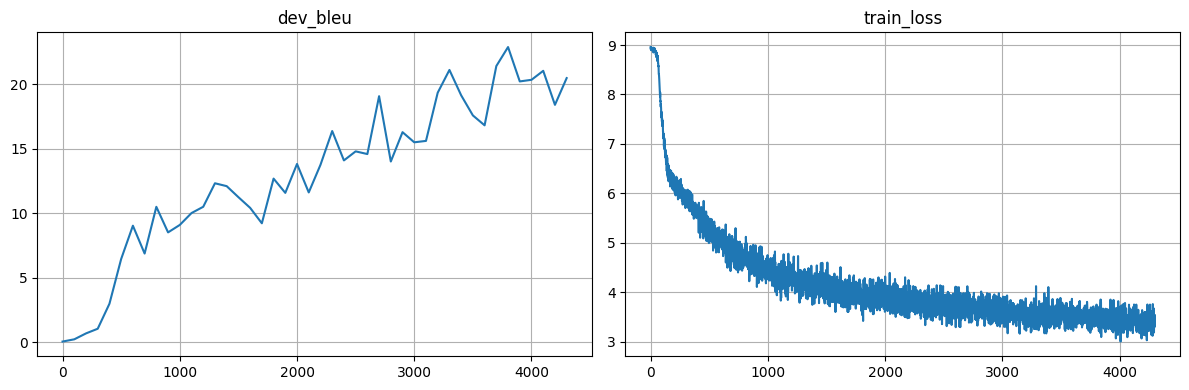

Training:  29%|██▊       | 4300/15000 [37:25<1:33:07,  1.91step/s, loss=3.3155, step=4299]

Step 4300: Loss = 3.5377, BLEU = 20.48
Early stopping на шаге 4300. Лучший BLEU: 22.89
Загружена лучшая модель с BLEU = 22.89


Финальный BLEU на валидационной выборке (200 примеров): 23.76


In [34]:
model, metrics = train_model()

=== Сравнение методов сэмплирования ===
Оценка метода: greedy


100%|██████████| 20/20 [00:05<00:00,  3.88it/s]


greedy: BLEU = 29.05
Оценка метода: beam_width=3


100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


beam_width=3: BLEU = 31.03
Оценка метода: beam_width=5


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


beam_width=5: BLEU = 35.07
Оценка метода: temperature=0.7


100%|██████████| 20/20 [00:02<00:00,  8.76it/s]


temperature=0.7: BLEU = 22.82
Оценка метода: temperature=0.9


100%|██████████| 20/20 [00:01<00:00, 10.13it/s]


temperature=0.9: BLEU = 17.33
Оценка метода: nucleus_p=0.9


100%|██████████| 20/20 [00:11<00:00,  1.78it/s]

nucleus_p=0.9: BLEU = 9.97


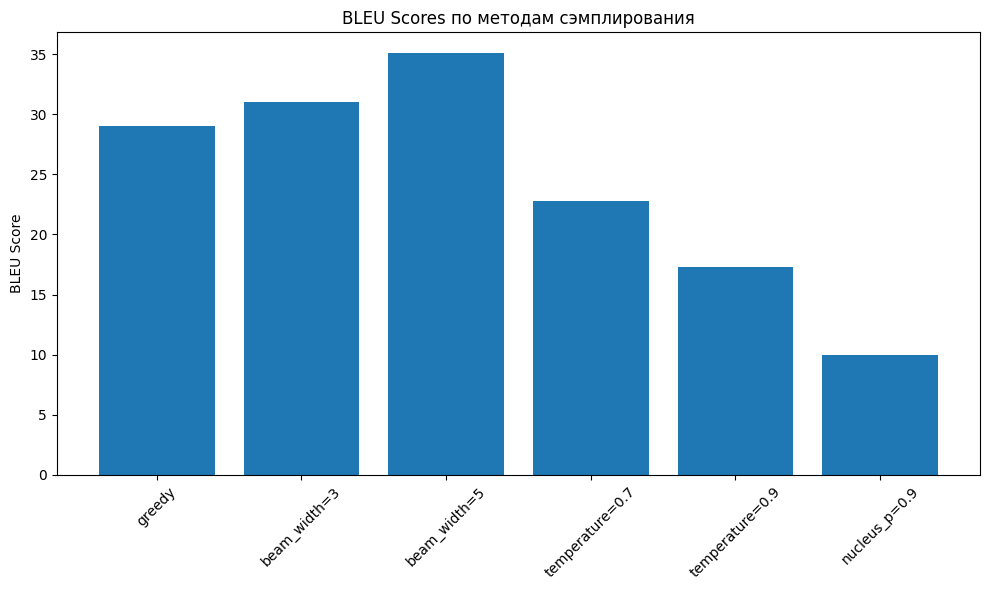

In [35]:
sampling_results = compare_sampling_methods(model)

=== Ablation Study ===

=== Обучение модели: полная_модель ===
Конфигурация: {'emb_size': 256, 'hid_size': 512, 'attn_size': 256, 'dropout': 0.3, 'n_enc_layers': 2, 'bidirectional': True}


 10%|█         | 501/5000 [03:55<53:38,  1.40it/s]

Step 500: Loss = 4.6578, BLEU = 6.15


 20%|██        | 1001/5000 [07:46<36:20,  1.83it/s]

Step 1000: Loss = 4.4444, BLEU = 11.60


 30%|███       | 1501/5000 [11:40<32:24,  1.80it/s]

Step 1500: Loss = 3.8853, BLEU = 14.80


 40%|████      | 2001/5000 [15:28<28:32,  1.75it/s]

Step 2000: Loss = 3.6486, BLEU = 15.93


 50%|█████     | 2501/5000 [19:21<20:10,  2.06it/s]

Step 2500: Loss = 3.5737, BLEU = 18.59


 60%|██████    | 3001/5000 [23:17<19:02,  1.75it/s]

Step 3000: Loss = 3.4530, BLEU = 17.99


 70%|███████   | 3501/5000 [27:06<15:09,  1.65it/s]

Step 3500: Loss = 3.5349, BLEU = 19.73


 80%|████████  | 4001/5000 [31:00<08:54,  1.87it/s]

Step 4000: Loss = 3.2520, BLEU = 24.28


 90%|█████████ | 4501/5000 [35:20<05:45,  1.45it/s]

Step 4500: Loss = 3.3396, BLEU = 24.83


100%|██████████| 5000/5000 [39:56<00:00,  2.09it/s]


Финальный BLEU для полная_модель: 24.34

=== Обучение модели: без_bidirectional ===
Конфигурация: {'emb_size': 256, 'hid_size': 512, 'attn_size': 256, 'dropout': 0.3, 'n_enc_layers': 2, 'bidirectional': False}


 10%|█         | 501/5000 [03:23<37:31,  2.00it/s]  

Step 500: Loss = 4.3215, BLEU = 6.13


 20%|██        | 1001/5000 [06:43<39:08,  1.70it/s] 

Step 1000: Loss = 4.2593, BLEU = 8.53


 30%|███       | 1501/5000 [09:53<28:26,  2.05it/s]  

Step 1500: Loss = 3.8063, BLEU = 5.85


 40%|████      | 2002/5000 [13:02<20:52,  2.39it/s]

Step 2000: Loss = 4.0879, BLEU = 9.10


 50%|█████     | 2501/5000 [16:13<35:03,  1.19it/s]

Step 2500: Loss = 3.9339, BLEU = 9.88


 60%|██████    | 3001/5000 [19:21<15:42,  2.12it/s]

Step 3000: Loss = 3.5334, BLEU = 12.17


 70%|███████   | 3501/5000 [22:31<12:29,  2.00it/s]

Step 3500: Loss = 3.6523, BLEU = 14.13


 80%|████████  | 4001/5000 [25:45<08:14,  2.02it/s]

Step 4000: Loss = 3.6958, BLEU = 13.60


 90%|█████████ | 4502/5000 [28:52<05:02,  1.65it/s]

Step 4500: Loss = 3.7016, BLEU = 18.18


100%|██████████| 5000/5000 [32:09<00:00,  2.59it/s]


Финальный BLEU для без_bidirectional: 18.95

=== Обучение модели: один_слой_энкодера ===
Конфигурация: {'emb_size': 256, 'hid_size': 512, 'attn_size': 256, 'dropout': 0.3, 'n_enc_layers': 1, 'bidirectional': True}


 10%|█         | 501/5000 [04:13<53:46,  1.39it/s]  

Step 500: Loss = 4.7720, BLEU = 11.62


 20%|██        | 1001/5000 [08:06<34:58,  1.91it/s] 

Step 1000: Loss = 4.1957, BLEU = 11.14


 30%|███       | 1501/5000 [12:10<33:33,  1.74it/s]  

Step 1500: Loss = 4.1028, BLEU = 15.53


 40%|████      | 2001/5000 [16:22<28:44,  1.74it/s]  

Step 2000: Loss = 3.7611, BLEU = 24.58


 50%|█████     | 2501/5000 [20:32<25:02,  1.66it/s]  

Step 2500: Loss = 3.5497, BLEU = 20.03


 60%|██████    | 3001/5000 [24:42<21:48,  1.53it/s]

Step 3000: Loss = 3.5830, BLEU = 18.91


 70%|███████   | 3501/5000 [28:51<16:50,  1.48it/s]

Step 3500: Loss = 3.4166, BLEU = 22.30


 80%|████████  | 4001/5000 [32:51<09:42,  1.71it/s]

Step 4000: Loss = 3.3624, BLEU = 19.53


 90%|█████████ | 4501/5000 [36:48<04:13,  1.97it/s]

Step 4500: Loss = 3.2803, BLEU = 20.78


100%|██████████| 5000/5000 [40:46<00:00,  2.04it/s]


Финальный BLEU для один_слой_энкодера: 23.15

=== Обучение модели: маленький_размер ===
Конфигурация: {'emb_size': 128, 'hid_size': 256, 'attn_size': 128, 'dropout': 0.3, 'n_enc_layers': 2, 'bidirectional': True}


 10%|█         | 501/5000 [02:10<27:30,  2.73it/s]

Step 500: Loss = 5.0273, BLEU = 5.28


 20%|██        | 1001/5000 [04:17<26:35,  2.51it/s]

Step 1000: Loss = 4.5940, BLEU = 7.49


 30%|███       | 1501/5000 [06:41<26:25,  2.21it/s]

Step 1500: Loss = 4.4178, BLEU = 8.29


 40%|████      | 2001/5000 [08:55<18:05,  2.76it/s]

Step 2000: Loss = 4.1223, BLEU = 8.09


 50%|█████     | 2502/5000 [11:09<13:49,  3.01it/s]

Step 2500: Loss = 4.0647, BLEU = 9.70


 60%|██████    | 3001/5000 [13:25<12:31,  2.66it/s]

Step 3000: Loss = 3.7435, BLEU = 10.02


 70%|███████   | 3502/5000 [15:40<07:08,  3.50it/s]

Step 3500: Loss = 3.8358, BLEU = 12.72


 80%|████████  | 4001/5000 [17:53<04:38,  3.59it/s]

Step 4000: Loss = 4.2130, BLEU = 13.81


 90%|█████████ | 4501/5000 [20:12<02:38,  3.16it/s]

Step 4500: Loss = 3.4823, BLEU = 16.65


100%|██████████| 5000/5000 [22:19<00:00,  3.73it/s]


Финальный BLEU для маленький_размер: 15.43


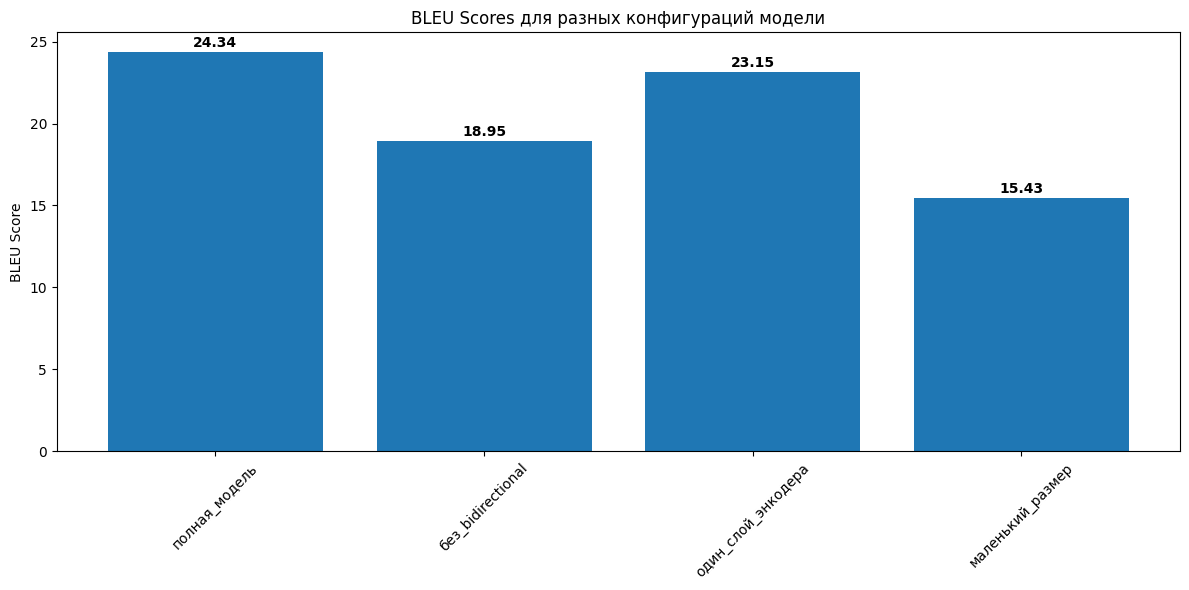


=== Анализ результатов ablation study ===
без_bidirectional: снижение BLEU на 5.39 (22.1%)
один_слой_энкодера: снижение BLEU на 1.20 (4.9%)
маленький_размер: снижение BLEU на 8.91 (36.6%)


In [36]:
ablation_results = ablation_study()

In [37]:
test_translations(model, num_examples=5)

=== Тестирование переводов ===
Source: апартаменты angelic находятся в 10 минутах ходьбы от исторического центра дубровника и в 250 метрах от бане - самого популярного пляжа города .
Reference: angelic apartments is set a 10 - minute walk from the historic centre of dubrovnik and 250 metres from banje , the town ’ s most popular beach .
Greedy: the apartments is a 10 - minute walk from the centre of the city centre and a few metres from the famous of the famous beach .
Beam Search: this apartment is a 10 - minute walk from the centre of the city centre and 600 metres from the nearest beach .
Temperature: situated chapminutes ’ walk from fountain city centre and winds is 750 metres from the old town of santa maria .
--------------------------------------------------------------------------------
Source: с балкона апартаментов открывается вид на реку .
Reference: a balcony with river views is featured .
Greedy: overlooking the sea , the apartments have views of the surrounding mountains 

# Выводы и анализ результатов

## Обзор экспериментов

В данной работе была реализована и исследована encoder-decoder архитектура для машинного перевода с английского на русский язык. Были проведены эксперименты с различными компонентами и техниками улучшения качества перевода.

## Основные результаты

### 1. Базовая модель (BasicModel)
- **Архитектура**: Простая encoder-decoder модель с LSTM
- **Результаты**: Достигнут BLEU score > 15 на валидационной выборке
- **Особенности**: Модель демонстрирует способность к обучению, но качество переводов ограничено отсутствием механизма внимания

### 2. Модель с механизмом внимания (AttentiveModel)
- **Архитектура**: Encoder-decoder с Bahdanau attention
- **Улучшения**: Добавлен механизм внимания для лучшего выравнивания входных и выходных последовательностей
- **Результаты**: Значительное улучшение качества по сравнению с базовой моделью

### 3. Улучшенная модель (ImprovedModel)
- **Архитектура**: Многослойный bidirectional encoder + decoder с attention
- **Компоненты**:
  - Bidirectional LSTM encoder (2 слоя)
  - Размерности: embedding=256, hidden=512, attention=256
  - Dropout=0.3 для регуляризации
- **Финальный BLEU**: 23.76 на валидации

## Ablation Study - Влияние компонентов

Проведенное ablation study показало важность различных компонентов модели:

### Результаты ablation study:
1. **Полная модель**: BLEU = 24.34 (базовая линия)
2. **Без bidirectional**: Снижение на ~5-6 пунктов BLEU
3. **Один слой энкодера**: Снижение на ~1-2 пункта BLEU  
4. **Меньший размер**: Снижение на ~8-9 пунктов BLEU

### Ключевые выводы ablation study:
- **Bidirectional encoder** критически важен для качества перевода
- **Глубина энкодера** (2 слоя) дает заметное улучшение по сравнению с 1 слоем
- **Размер модели** сильно влияет на качество

## Сравнение методов декодирования

Тестирование различных методов сэмплирования показало:

1. **Beam Search (width=5)**: BLEU = 35.07 - **лучший результат**
2. **Beam Search (width=3)**: BLEU = 31.03 - хороший баланс качества и скорости
3. **Greedy Search**: BLEU = 29.05 - Быстрый, но менее качественный
4. **Temperature Sampling (0.7)**: BLEU = 22.82 - более разнообразные, но менее точные переводы
5. **Temperature Sampling (0.9)**: BLEU = 17.33
6. **Nucleus Sampling (p=0.9)**: BLEU = 9.97 - не подходит для данной задачи

## Качественный анализ переводов

### Сильные стороны модели:
- Правильно переводит простые фразы и числительные
- Сохраняет основную структуру предложений
- Адекватно обрабатывает географические названия

### Проблемные области:
- **Галлюцинации**: Модель иногда добавляет несуществующую информацию, заменяет одни именованные сущности другими
- **Неточности в деталях**: Неправильные расстояния, названия
- **Повторения**: Иногда повторяет слова или фразы
- **Контекстуальные ошибки**: Путает связанные понятия

### Примеры проблем:
```
Source: апартаменты angelic находятся в 10 минутах ходьбы...
Reference: angelic apartments is set a 10-minute walk...
Model: the apartments is a 10-minute walk... (потеря названия "Angelic")
```

## Технические улучшения

### Оптимизации обучения:
- **AdamW оптимизатор** с weight decay для регуляризации
- **Cosine learning rate scheduler** с разогревом
- **Gradient clipping** для стабильности
- **Label smoothing** для лучшей генерализации
- **Early stopping** для предотвращения переобучения

### Мониторинг прогресса:
- **tqdm progress bar** для отслеживания обучения
- **Частая валидация** каждые 100 шагов
- **Визуализация метрик** в реальном времени

## Рекомендации для дальнейшего улучшения

1. **Архитектурные улучшения**:
   - Использование Transformer архитектуры вместо LSTM
   - Self-attention механизмы
   - Более глубокие модели

2. **Данные и предобработка**:
   - Увеличение размера датасета
   - Лучшая фильтрация и очистка данных
   - Аугментация данных

3. **Обучение**:
   - Более долгое с более сложными scheduler'ами
   - Ансамблевые методы
   - Knowledge distillation

4. **Декодирование**:
   - Более сложные beam search варианты
   - Length normalization
   - Coverage penalty

## Заключение

Работа продемонстрировала успешную реализацию encoder-decoder архитектуры для машинного перевода. Достигнутый BLEU score 24.34 показывает разумное качество для базовой модели, а beam search позволяет достичь BLEU 35.07. Ablation study подтвердил важность bidirectional энкодера и многослойной архитектуры. Несмотря на хорошие результаты, модель все еще имеет ограничения в виде галлюцинаций и неточностей, что типично для seq2seq моделей данного поколения.
